In [1]:
import subject_data
   

100%|██████████| 226/226 [00:24<00:00,  9.32it/s]


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time

In [3]:
cgm = subject_data.df_CGM

In [4]:
cgm.head()
cgm['time'] = pd.to_datetime(cgm['time'])


In [5]:
def count_exceeding_intervals(group, time_diff_minutes):
    # Filter times between 12 AM and 6 AM
    group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]
    
    # Sort by time
    group = group.sort_values(by='time')
    
    # Calculate time differences between consecutive measurements
    group['time_diff'] = group['time'].diff()
    
    # Count intervals where time difference exceeds the specified minutes
    count = (group['time_diff'] > timedelta(minutes=time_diff_minutes)).sum()
    
    return count

In [6]:
# Specify the time difference threshold (in minutes)
time_diff_threshold = 20  # You can change this value as needed

# Apply the function to each patient ID
result = cgm.groupby('id').apply(lambda x: count_exceeding_intervals(x, time_diff_threshold))

print(result)

id
2      244
3      267
5      204
7      293
8      204
      ... 
289     62
290    251
291    227
292    236
293    220
Length: 226, dtype: int64


In [7]:
# Function to count nights with more than 8 gaps of 20 minutes
def count_nights_without_gaps(group, min_gap_minutes=20, max_gap_minutes=25, gap_threshold=8):
    # Filter times between 12 AM and 6 AM
    group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]

    # Use just the date to identify the night
    group['night'] = group['time'].dt.date

    # Calculate time differences within each night
    group['time_diff'] = group.groupby('night')['time'].diff()

    gap_counts = group.groupby('night').apply(lambda x: (x['time_diff'] > timedelta(minutes=min_gap_minutes)).sum())
    big_gap_counts = group.groupby('night').apply(lambda x: (x['time_diff'] > timedelta(minutes=max_gap_minutes)).sum())

    group = group.merge(gap_counts.rename('gap_counts'), left_on='night', right_index=True)
    group = group.merge(big_gap_counts.rename('big_gap_counts'), left_on='night', right_index=True)

    result = group[(group['gap_counts'] < gap_threshold) & (group['big_gap_counts'] < 1)]

    return result

In [8]:
print(np.logical_and((np.array([1,2,3])<2 ), (np.array([1,2,3])<3)))

[ True False False]


In [9]:
# Apply the function to each patient ID

result = cgm.groupby('id').apply(count_nights_without_gaps)

print(result)

               id                time    bgl       night       time_diff  \
id                                                                         
2   1143099     2 2015-05-23 00:01:25   82.0  2015-05-23             NaT   
    1143303     2 2015-05-23 00:06:25   80.0  2015-05-23 0 days 00:05:00   
    1143507     2 2015-05-23 00:11:25   82.0  2015-05-23 0 days 00:05:00   
    1143711     2 2015-05-23 00:16:25   83.0  2015-05-23 0 days 00:05:00   
    1143914     2 2015-05-23 00:21:25   86.0  2015-05-23 0 days 00:05:00   
...           ...                 ...    ...         ...             ...   
293 12365667  293 2015-11-30 05:38:08  163.0  2015-11-30 0 days 00:05:00   
    12365863  293 2015-11-30 05:43:08  163.0  2015-11-30 0 days 00:05:00   
    12366060  293 2015-11-30 05:48:08  163.0  2015-11-30 0 days 00:05:00   
    12366258  293 2015-11-30 05:53:08  163.0  2015-11-30 0 days 00:05:00   
    12366454  293 2015-11-30 05:58:08  163.0  2015-11-30 0 days 00:05:00   

           

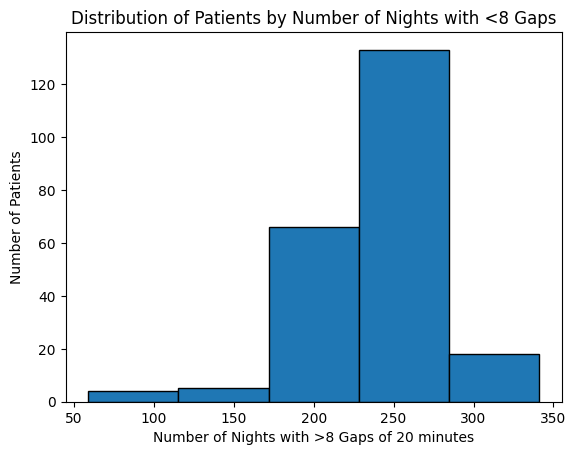

In [23]:
plt.hist(result, bins=5, edgecolor='black')

plt.title('Distribution of Patients by Number of Nights with <8 Gaps')
plt.xlabel('Number of Nights with <8 Gaps of 20 minutes')
plt.ylabel('Number of Patients')

plt.show()

In [24]:
# Function to count hypoglycemic nights with fewer than 8 gaps of 20 minutes
def count_hypoglycemic_nights(group, gap_minutes=20, gap_threshold=4, hypoglycemic_threshold=70):
    # Filter times between 12 AM and 6 AM
    group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]

    # Use just the date to identify the night
    group['night'] = group['time'].dt.date

    # Calculate time differences within each night
    group['time_diff'] = group.groupby('night')['time'].diff()

    # Identify nights with fewer than gap_threshold gaps
    nights_with_fewer_gaps = group.groupby('night').apply(lambda x: (x['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold)

    # Calculate the percentage of readings below the hypoglycemic threshold for each night
    hypoglycemic_nights = group.groupby('night').apply(lambda x: (x['bgl'] < hypoglycemic_threshold).sum() / len(x) > 0.05)

    # Count nights that are both hypoglycemic and have fewer gaps
    return sum(nights_with_fewer_gaps & hypoglycemic_nights)


In [26]:
# Apply the function to each patient ID
result = cgm.groupby('id').apply(count_hypoglycemic_nights)

print(result)

id
2      18
3      43
5      18
7      43
8      35
       ..
289     9
290    38
291    28
292    28
293    10
Length: 226, dtype: int64


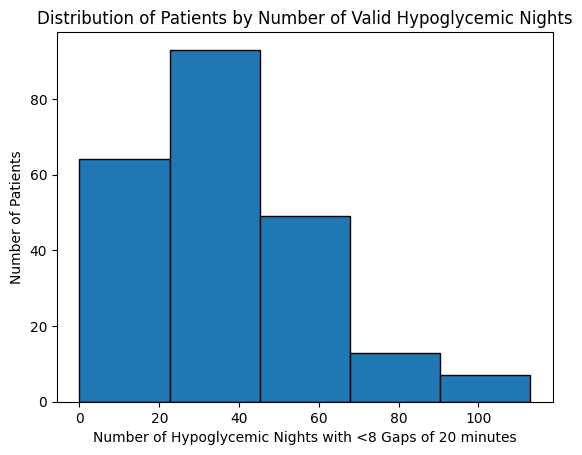

In [28]:
plt.hist(result, bins=5, edgecolor='black')

plt.title('Distribution of Patients by Number of Valid Hypoglycemic Nights')
plt.xlabel('Number of Hypoglycemic Nights with <8 Gaps of 20 minutes')
plt.ylabel('Number of Patients')

plt.show()

In [29]:
print(result.sum())

8394


id
2      23
3      47
5      20
7      47
8      40
       ..
289    10
290    41
291    29
292    29
293    11
Length: 226, dtype: int64


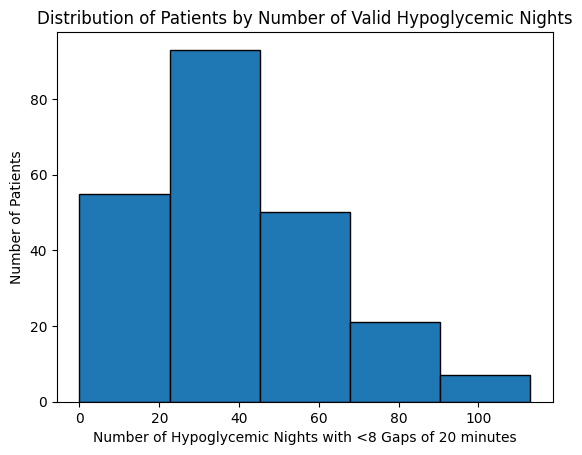

In [17]:
night_df = 0
# Function to count hypoglycemic nights with fewer than 8 gaps of 20 minutes for both night and corresponding day
def count_hypoglycemic_nights(group, gap_minutes=20, gap_threshold=8, hypoglycemic_threshold=70):
    global night_df
    # Function to identify the day corresponding to a given night (6 AM previous date to 11:59 PM)
    def get_corresponding_day(date_time):
        if date_time.hour < 6:  # If before 6 AM, it belongs to the previous day
            return date_time.date() - timedelta(days=1)
        else:
            return date_time.date()

    # Identify the corresponding day for each measurement
    group['corresponding_day'] = group['time'].apply(get_corresponding_day)

    # Calculate time differences within each day
    group['time_diff'] = group.groupby('corresponding_day')['time'].diff()

    # Function to check if there are fewer than gap_threshold gaps
    def has_fewer_gaps(subgroup):
        return (subgroup['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold

    # Identify days with fewer than gap_threshold gaps
    days_with_fewer_gaps = group.groupby('corresponding_day').apply(has_fewer_gaps)

    # Use just the date to identify the night
    group['night'] = group['time'].dt.date

    # Filter for night time measurements between 12 AM and 6 AM
    nights_group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]

    # Calculate the percentage of readings below the hypoglycemic threshold for each night
    hypoglycemic_nights = nights_group.groupby('night').apply(lambda x: (x['bgl'] < hypoglycemic_threshold).sum() / len(x) > 0.04)
    night_df = hypoglycemic_nights & days_with_fewer_gaps.reindex(hypoglycemic_nights.index, fill_value=False)

    # Count nights that are hypoglycemic and the corresponding day has fewer gaps
    return sum(hypoglycemic_nights & days_with_fewer_gaps.reindex(hypoglycemic_nights.index, fill_value=False))

# Apply the function to each patient ID
result = cgm.groupby('id').apply(count_hypoglycemic_nights)

print(result)

plt.hist(result, bins=5, edgecolor='black')

plt.title('Distribution of Patients by Number of Valid Hypoglycemic Nights')
plt.xlabel('Number of Hypoglycemic Nights with <8 Gaps of 20 minutes')
plt.ylabel('Number of Patients')

plt.show()

In [21]:
night_df 
# find when night_df is true
nh_night_df = night_df[night_df == True]
nh_night_df


night
2015-04-30    True
2015-05-04    True
2015-05-05    True
2015-05-06    True
2015-05-12    True
2015-08-03    True
2015-08-06    True
2015-08-15    True
2015-09-09    True
2015-11-01    True
2015-11-16    True
dtype: bool

In [31]:
# Function to count valid days and nights based on reading and gap criteria

def count_valid_days_nights(group, gap_minutes=20, gap_threshold=8, night_reading_threshold=55, day_reading_threshold=150, hypoglycemic=False, hypoglycemic_threshold=70):
    # Function to identify the day corresponding to a given night (6 AM previous date to 11:59 PM)
    def get_corresponding_day(date_time):
        if date_time.hour < 6:  # If before 6 AM, it belongs to the previous day
            return date_time.date() - timedelta(days=1)
        else:
            return date_time.date()

    # Identify the corresponding day for each measurement
    group['corresponding_day'] = group['time'].apply(get_corresponding_day)

    # Calculate time differences within each day
    group['time_diff'] = group.groupby('corresponding_day')['time'].diff()

    # Function to check if there are fewer than gap_threshold gaps and enough readings
    def has_fewer_gaps_and_enough_readings(subgroup):
        return ((subgroup['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold) and (len(subgroup) > day_reading_threshold)

    # Identify days with fewer than gap_threshold gaps and more than day_reading_threshold readings
    days_with_fewer_gaps = group.groupby('corresponding_day').apply(has_fewer_gaps_and_enough_readings)

    # Use just the date to identify the night
    group['night'] = group['time'].dt.date

    # Filter for night time measurements between 12 AM and 6 AM
    nights_group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]

    # Check if each night has more than night_reading_threshold readings
    nights_with_enough_readings = nights_group.groupby('night').apply(lambda x: len(x) > night_reading_threshold)

    # Calculate the percentage of readings below the hypoglycemic threshold for each night if hypoglycemic is True
    if hypoglycemic:
        hypoglycemic_nights = nights_group.groupby('night').apply(lambda x: (x['bgl'] < hypoglycemic_threshold).sum() / len(x) > 0.04)
        valid_nights = hypoglycemic_nights & nights_with_enough_readings
    else:
        valid_nights = nights_with_enough_readings
        
    # Count valid nights where the corresponding day also meets criteria
    return sum(valid_nights & days_with_fewer_gaps.reindex(valid_nights.index, fill_value=False))

# Apply the function to each patient ID
hypo_result = cgm.groupby('id').apply(count_valid_days_nights)
"""
print(hypo_result)

plt.hist(hypo_result, bins=5, edgecolor='black')

plt.title('Distribution of Patients by Number of Valid Days/Nights')
plt.xlabel('Number of Hypoglycemic Nights with <8 Gaps of 20 minutes')
plt.ylabel('Number of Patients')

plt.show()

print(hypo_result.sum())
"""

KeyboardInterrupt: 

In [36]:
def count_valid_days_nights(group, gap_minutes=20, gap_threshold=8, night_reading_threshold=55, day_reading_threshold=150, hypoglycemic_threshold=70, hyperglycemic_threshold=180):
    def get_corresponding_day(date_time):
        if date_time.hour < 6:
            return date_time.date() - timedelta(days=1)
        else:
            return date_time.date()
    
    group['corresponding_day'] = group['time'].apply(get_corresponding_day)
    group['time_diff'] = group.groupby('corresponding_day')['time'].diff()
    
    def has_fewer_gaps_and_enough_readings(subgroup):
        return ((subgroup['time_diff'] > timedelta(minutes=gap_minutes)).sum() < gap_threshold) and (len(subgroup) > day_reading_threshold)
    
    days_with_fewer_gaps = group.groupby('corresponding_day').apply(has_fewer_gaps_and_enough_readings)
    group['night'] = group['time'].dt.date
    nights_group = group[(group['time'].dt.hour >= 0) & (group['time'].dt.hour < 6)]
    nights_with_enough_readings = nights_group.groupby('night').apply(lambda x: len(x) > night_reading_threshold)

    # Check for valid days and nights
    valid_days = group[group['corresponding_day'].isin(days_with_fewer_gaps.index[days_with_fewer_gaps])]
    valid_nights = nights_group[nights_group['night'].isin(nights_with_enough_readings.index[nights_with_enough_readings])]
    
    # Combine valid days and nights
    valid_readings = pd.concat([valid_days, valid_nights])
    
    # Calculate mean and variance
    mean_bgl = valid_readings['bgl'].mean()
    variance_bgl = valid_readings['bgl'].var()
    
    # Calculate percentage of readings below 70 and above 180
    percent_below_70 = (valid_readings['bgl'] < hypoglycemic_threshold).sum() / len(valid_readings) * 100
    percent_above_180 = (valid_readings['bgl'] > hyperglycemic_threshold).sum() / len(valid_readings) * 100
    
    # Return the calculated values
    return mean_bgl, variance_bgl, percent_below_70, percent_above_180, sum(days_with_fewer_gaps), sum(nights_with_enough_readings)

mean_bgl, variance_bgl, percent_below_70, percent_above_180, valid_days_count, valid_nights_count = count_valid_days_nights(cgm)


In [39]:
print(mean_bgl, np.sqrt(variance_bgl), percent_below_70, percent_above_180, valid_days_count, valid_nights_count)

160.90423046723046 64.93037362281814 3.795387802830488 33.383071783758446 523 527


In [34]:
print(hypo_result.head())


id            
2   2015-05-22    False
    2015-05-23     True
    2015-05-24     True
    2015-05-25     True
    2015-05-26     True
dtype: bool


id
2      241
3      254
5      190
7      279
8      190
      ... 
289     56
290    224
291    220
292    224
293    216
Length: 226, dtype: int64


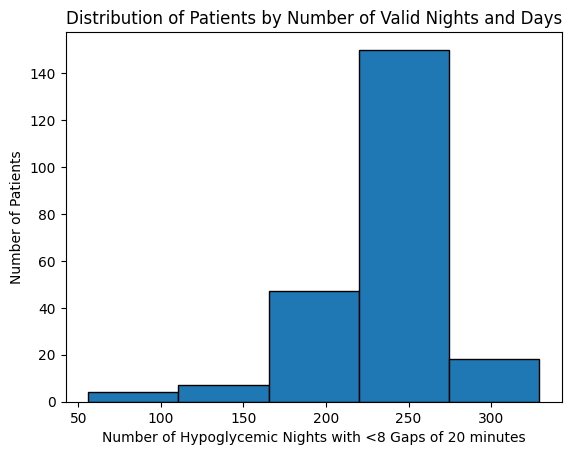

52279


In [50]:
# Apply the function to each patient ID
result = cgm.groupby('id').apply(count_valid_days_nights, hypoglycemic=False)

print(result)

plt.hist(result, bins=5, edgecolor='black')

plt.title('Distribution of Patients by Number of Valid Nights and Days')
plt.xlabel('Number of Hypoglycemic Nights with <8 Gaps of 20 minutes')
plt.ylabel('Number of Patients')

plt.show()

print(result.sum())


In [43]:
print(result.sum())

8375


In [33]:
print(result.sum())

14753


In [29]:
cgm = subject_data.df_CGM
cgm['time'] = pd.to_datetime(cgm['time'], yearfirst=True)
# Find the index of the first occurrence of 12 AM (midnight)

filtered_dfs = []

# Define the reference date as January 1, 2000
# To Normalize all start times
reference_date = pd.to_datetime('2000-01-01')

sampling_period = timedelta(hours=1)

# Create an empty DataFrame to store the combined results
combined_df = pd.DataFrame()

# Group the DataFrame by 'id' and filter each group separately
for idname, group in cgm.groupby('id'):
    
    date_offset = (group['time'].min().date() - reference_date.date()).days
    
    # Add the offset to all dates in the group
    group['time'] = group['time'] - pd.DateOffset(days=date_offset)

    next_day = group['time'].min().date() + pd.Timedelta(days=1)

    min_time_next_day = group[group['time'].dt.date == next_day]['time'].min()
    
    filtered_group = group[group['time'] >= min_time_next_day]

    resampled_group = filtered_group.resample(sampling_period, on='time').agg({
        'bgl': ['mean', 'std', 'count']
    })

    resampled_group.reset_index(inplace=True)

    resampled_group.columns = ['time', f'mean_bgl_id_{idname}', f'std_bgl_id_{idname}', f'count_id_{idname}']

    resampled_group.set_index('time', inplace=True)

    # Calculate TIR, TBR, TAR based on 'mean_bgl_id_idname' column
    resampled_group[f'TIR_id_{idname}'] = (resampled_group[f'mean_bgl_id_{idname}'] >= 70) & (resampled_group[f'mean_bgl_id_{idname}'] <= 180)
    resampled_group[f'TBR_id_{idname}'] = resampled_group[f'mean_bgl_id_{idname}'] < 70
    resampled_group[f'TAR_id_{idname}'] = resampled_group[f'mean_bgl_id_{idname}'] > 180
    
    # Convert boolean values to 1s and 0s
    resampled_group[f'TIR_id_{idname}'] = resampled_group[f'TIR_id_{idname}'].astype(int)
    resampled_group[f'TBR_id_{idname}'] = resampled_group[f'TBR_id_{idname}'].astype(int)
    resampled_group[f'TAR_id_{idname}'] = resampled_group[f'TAR_id_{idname}'].astype(int)

    # Join the resampled group with the combined DataFrame
    if combined_df.empty:
        combined_df = resampled_group
    else:
        combined_df = combined_df.merge(resampled_group, on='time', how='outer')

combined_df['night'] = (combined_df.index.hour >= 0) & (combined_df.index.hour < 6)
combined_df['night'] = combined_df['night'].astype(int)

# Fill NaN values in 'count_id_idname' columns with 0 for each group
    #['2','3'] cgm['id'].unique()
for idname in cgm['id'].unique():
    combined_df[f'count_id_{idname}'] = combined_df[f'count_id_{idname}'].fillna(0)

    #INTERPOLATION HERE
    combined_df[f'mean_bgl_id_{idname}'].interpolate(method='linear', inplace=True)
    #


In [48]:
print(combined_df.head(5))

"""
start-time: NaN
end-time: different for every patient
time  bgl_id1 bgl_id2

weekend vs weekday. (check that it starts on weekday monday)

time id bgl

mean glucose
for each id mean of bgl
for each id std of bgl
for each id count of bgl


CHO, adv event
adv_ent_type_A
1, 0,


bolus
4.5,0,0,0,0,03.4
"""


                     mean_bgl_id_2  std_bgl_id_2  count_id_2  TIR_id_2  \
time                                                                     
2000-01-02 00:00:00      86.750000      5.189587        12.0       1.0   
2000-01-02 01:00:00     102.416667      9.949494        12.0       1.0   
2000-01-02 02:00:00     134.916667     14.260297        12.0       1.0   
2000-01-02 03:00:00     153.500000      3.680415        12.0       1.0   
2000-01-02 04:00:00     152.500000      6.171783        12.0       1.0   

                     TBR_id_2  TAR_id_2  mean_bgl_id_3  std_bgl_id_3  \
time                                                                   
2000-01-02 00:00:00       0.0       0.0     217.166667     11.011014   
2000-01-02 01:00:00       0.0       0.0     184.250000      6.824088   
2000-01-02 02:00:00       0.0       0.0     163.333333      5.069218   
2000-01-02 03:00:00       0.0       0.0     148.000000      6.466698   
2000-01-02 04:00:00       0.0       0.0     125.1

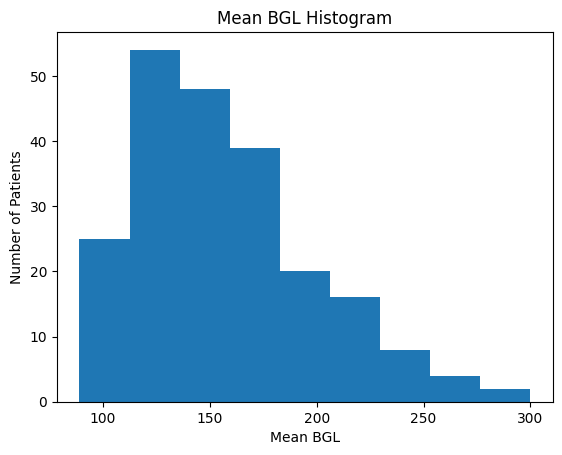

In [32]:
# Calculate the mean of 'mean_bgl' for each 'idname'
mean_bgl_per_id = combined_df[[f'mean_bgl_id_{idname}' for idname in cgm['id'].unique()]].mean(axis=0)

# Evenly spaced buckets for the mean of 'mean_bgl' from mean_bgl_per_id.min() to mean_bgl_per_id.max()
mean_bgl_bins = np.linspace(mean_bgl_per_id.min(), 300, 10)

# Count of the number of values in each bucket
mean_bgl_bin_counts = np.histogram(mean_bgl_per_id, bins=mean_bgl_bins)[0]
# Plot the histogram
plt.hist(mean_bgl_per_id, bins=mean_bgl_bins)
plt.xlabel('Mean BGL')
plt.ylabel('Number of Patients')
plt.title('Mean BGL Histogram')
plt.show()


"""
maybe because of NaN.
"""

In [35]:
mean_bgl_per_id.isna().sum() # where first or last values are NaNs

9

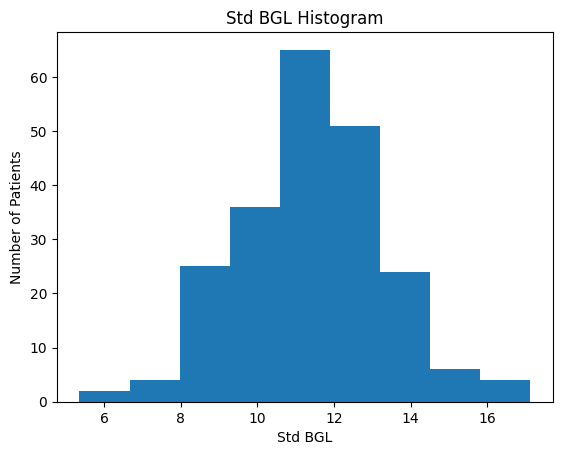

In [33]:
# same as above for std_bgl
std_bgl_per_id = combined_df[[f'std_bgl_id_{idname}' for idname in cgm['id'].unique()]].mean(axis=0)
std_bgl_bins = np.linspace(std_bgl_per_id.min(), std_bgl_per_id.max(), 10)
std_bgl_bin_counts = np.histogram(std_bgl_per_id, bins=std_bgl_bins)[0]
plt.hist(std_bgl_per_id, bins=std_bgl_bins)
plt.xlabel('Std BGL')
plt.ylabel('Number of Patients')
plt.title('Std BGL Histogram')
plt.show()

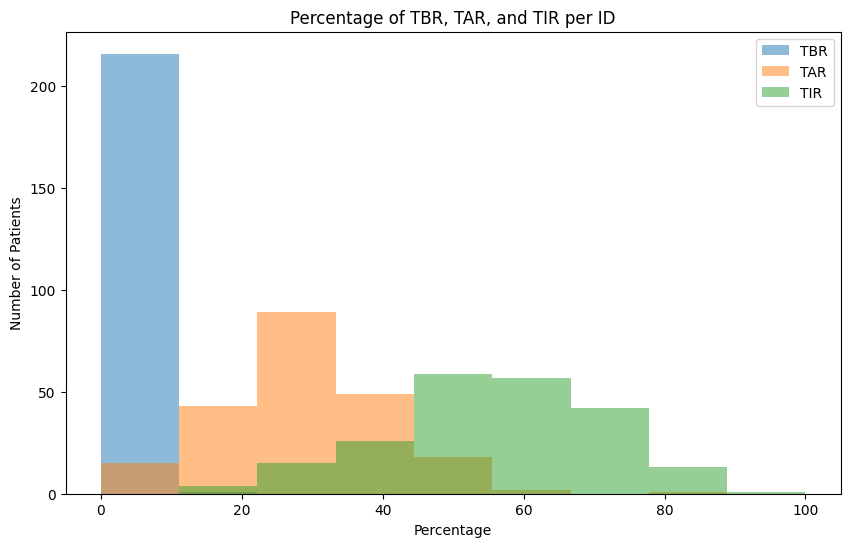

In [34]:
# Calculate the percentage of TBR, TAR, and TIR per ID
tbr_percentage_per_id = combined_df[[f'TBR_id_{idname}' for idname in cgm['id'].unique()]].mean(axis=0) * 100
tar_percentage_per_id = combined_df[[f'TAR_id_{idname}' for idname in cgm['id'].unique()]].mean(axis=0) * 100
tir_percentage_per_id = combined_df[[f'TIR_id_{idname}' for idname in cgm['id'].unique()]].mean(axis=0) * 100

# Create evenly spaced bins for the percentage values
percentage_bins = np.linspace(0, 100, 10)

# Calculate the count of values in each bin for TBR, TAR, and TIR
tbr_bin_counts = np.histogram(tbr_percentage_per_id, bins=percentage_bins)[0]
tar_bin_counts = np.histogram(tar_percentage_per_id, bins=percentage_bins)[0]
tir_bin_counts = np.histogram(tir_percentage_per_id, bins=percentage_bins)[0]

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(tbr_percentage_per_id, bins=percentage_bins, alpha=0.5, label='TBR')
plt.hist(tar_percentage_per_id, bins=percentage_bins, alpha=0.5, label='TAR')
plt.hist(tir_percentage_per_id, bins=percentage_bins, alpha=0.5, label='TIR')
plt.xlabel('Percentage')
plt.ylabel('Number of Patients')
plt.title('Percentage of TBR, TAR, and TIR per ID')
plt.legend()
plt.show()

"""
Lots of people have hypoglycaemia
Smothe method - increase minority class by (rebalance dataset)

NH vs DH. check night time.
3 consecutive values below range -> this night is hypoglycaemic
"""


time
0     3.275721
1     3.281984
2     3.284857
3     3.281607
4     3.280529
5     3.277015
6     3.260394
7     3.221449
8     3.187168
9     3.169523
10    3.173521
11    3.191221
12    3.212681
13    3.214391
14    3.212746
15    3.212120
16    3.208731
17    3.208569
18    3.202806
19    3.183709
20    3.185965
21    3.212319
22    3.244982
23    3.265449
dtype: float64


/var/folders/6j/zxy_nmpx04gg6ssx89r9gl5h0000gn/T/ipykernel_703/4114200548.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour', y='Average Count', data=hourly_counts_df, palette="viridis")


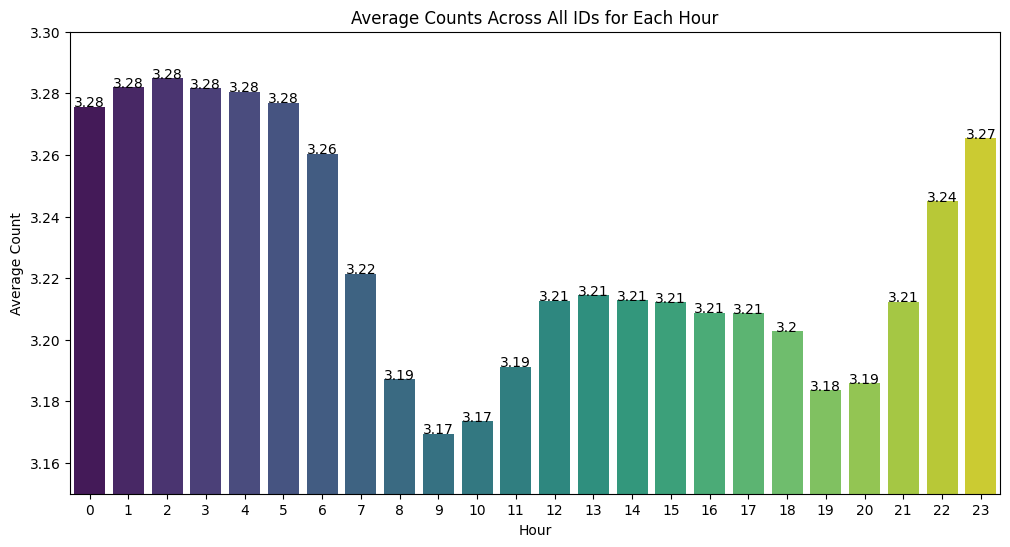

"\n# Plot the hourly counts\nplt.plot(hourly_counts.index, hourly_counts.values)\nplt.xlabel('Hour')\nplt.ylabel('Average Count')\nplt.title('Average Counts Across All IDs for Each Hour')\nplt.show()\n"

In [42]:
# Group the combined DataFrame by hour and calculate the mean of 'count_id_idname' for each hour
hourly_counts = combined_df.groupby(combined_df.index.hour)[[f'count_id_{idname}' for idname in cgm['id'].unique()]].mean().mean(axis=1)
print(hourly_counts)

# Convert it to a DataFrame for use with Seaborn
hourly_counts_df = pd.DataFrame({'Hour': hourly_counts.index, 'Average Count': hourly_counts.values})

# Plotting the histogram using Seaborn
plt.figure(figsize=(12, 6))  # Adjust the size as needed
sns.barplot(x='Hour', y='Average Count', data=hourly_counts_df, palette="viridis")

# Adding the count above each bar
for index, row in hourly_counts_df.iterrows():
    plt.text(row.name, row['Average Count'], round(row['Average Count'], 2), color='black', ha="center")

plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.title('Average Counts Across All IDs for Each Hour')

# Setting the y-axis limit between 3 and 4
plt.ylim(3.15, 3.3)

plt.show()

"""
# Plot the hourly counts
plt.plot(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.title('Average Counts Across All IDs for Each Hour')
plt.show()
"""


In [50]:
# Group the combined DataFrame by hour and count the number of ids where count_id_{idname} is less than 8 for each hour
hourly_ids_less_than_8 = combined_df.groupby(combined_df.index.hour)[[f'count_id_{idname}' for idname in cgm['id'].unique()]].apply(lambda x: (x < 3).sum()).sum(axis=1)

# Print the result
print(hourly_ids_less_than_8)


time
0     134626
1     134590
2     134529
3     134581
4     134609
5     134711
6     134984
7     135432
8     135636
9     135748
10    135622
11    135414
12    135142
13    135043
14    135010
15    134977
16    135036
17    135139
18    135288
19    135478
20    135462
21    135268
22    134965
23    134727
dtype: int64


In [30]:
combined_df[f'mean_bgl_id_217'].interpolate(method='linear', inplace=True)
print(combined_df['mean_bgl_id_217'])

time
2000-01-02 00:00:00      NaN
2000-01-02 01:00:00      NaN
2000-01-02 02:00:00      NaN
2000-01-02 03:00:00      NaN
2000-01-02 04:00:00      NaN
                       ...  
2002-04-01 03:00:00    266.0
2002-04-01 04:00:00    266.0
2002-04-01 05:00:00    266.0
2002-04-01 06:00:00    266.0
2002-04-01 07:00:00    266.0
Name: mean_bgl_id_217, Length: 19688, dtype: float64


id                      293
time    2015-05-05 06:00:32
bgl                    51.0
dtype: object


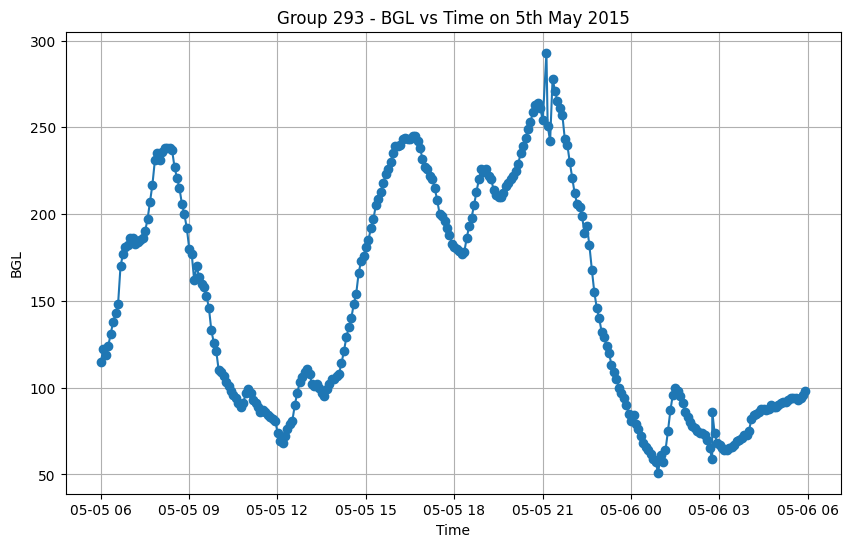

In [28]:
# Specify the group (change this to your desired group ID)
selected_group_id = 293

# Filter the DataFrame for the selected group
selected_group = cgm[cgm['id'] == selected_group_id]

# Filter rows for 1st November 2015 6AM to 2nd November 2015 6AM
morning = pd.to_datetime('2015-05-05 06:00:00')
day_data = selected_group[(selected_group['time'] >= morning) & (selected_group['time'] < morning + pd.Timedelta(days=1))]

print(day_data.min())

# Create a plot for the selected group
plt.figure(figsize=(10, 6))
plt.plot(day_data['time'], day_data['bgl'], marker='o', linestyle='-')
plt.title(f'Group {selected_group_id} - BGL vs Time on 5th May 2015')
plt.xlabel('Time')
plt.ylabel('BGL')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
"""
1. splines
2. 

WORSTCASE:
8 gaps close to each other

1. num measurements in each hour where num > 8

consecutive missing values

gaps between measurements
number of big gaps. (how much to throw away)
"""

In [ ]:
"""

interface.pyArray programming with NumPy.
for each id, find something
for each 

training
val:
test: different people 

how many useful days in patient

[]data labels

ethics:
patient identification, privacy,A
replace BG

Next steps:

NOCTURNAL HYPO PREDICTION ONLY
SUMMARIZE WORKFLOW (BE CRITICAL/ WWW, EBI)

NH vs DH
number of gaps of different sizes for each patient within different time intervals
define: WHAT IS HYPO NIGHT - HOW MANY PER PATIENT.

HOW MANY USEFUL DAYS PER PATIENT (no big gaps, gaps can which can be interpolated)

For feature extraction:
1 row per day
label - hypo night vs not hypo night
"""